In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/Tenx/Week 10/BrentOilPrices.csv',parse_dates=['Date'],index_col=['Date'])

/tmp/ipython-input-3742398055.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df=pd.read_csv('/content/drive/MyDrive/Tenx/Week 10/BrentOilPrices.csv',parse_dates=['Date'],index_col=['Date'])


In [3]:
df.head()

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


In [ ]:
df.isna().sum()

,0
Price,0


In [3]:
#handle missing value
df['Price'] = df['Price'].interpolate(method='time')

In [4]:
#Log return
import numpy as np
df['Log_Return'] = np.log(df['Price']).diff().dropna()

In [5]:
#drop missing values
df=df.dropna()

In [ ]:
df.head()

,Price,Log_Return
Date,,
1987-05-21,18.45,-0.009709
1987-05-22,18.55,0.005405
1987-05-25,18.60,0.002692
1987-05-26,18.63,0.001612
1987-05-27,18.60,-0.001612


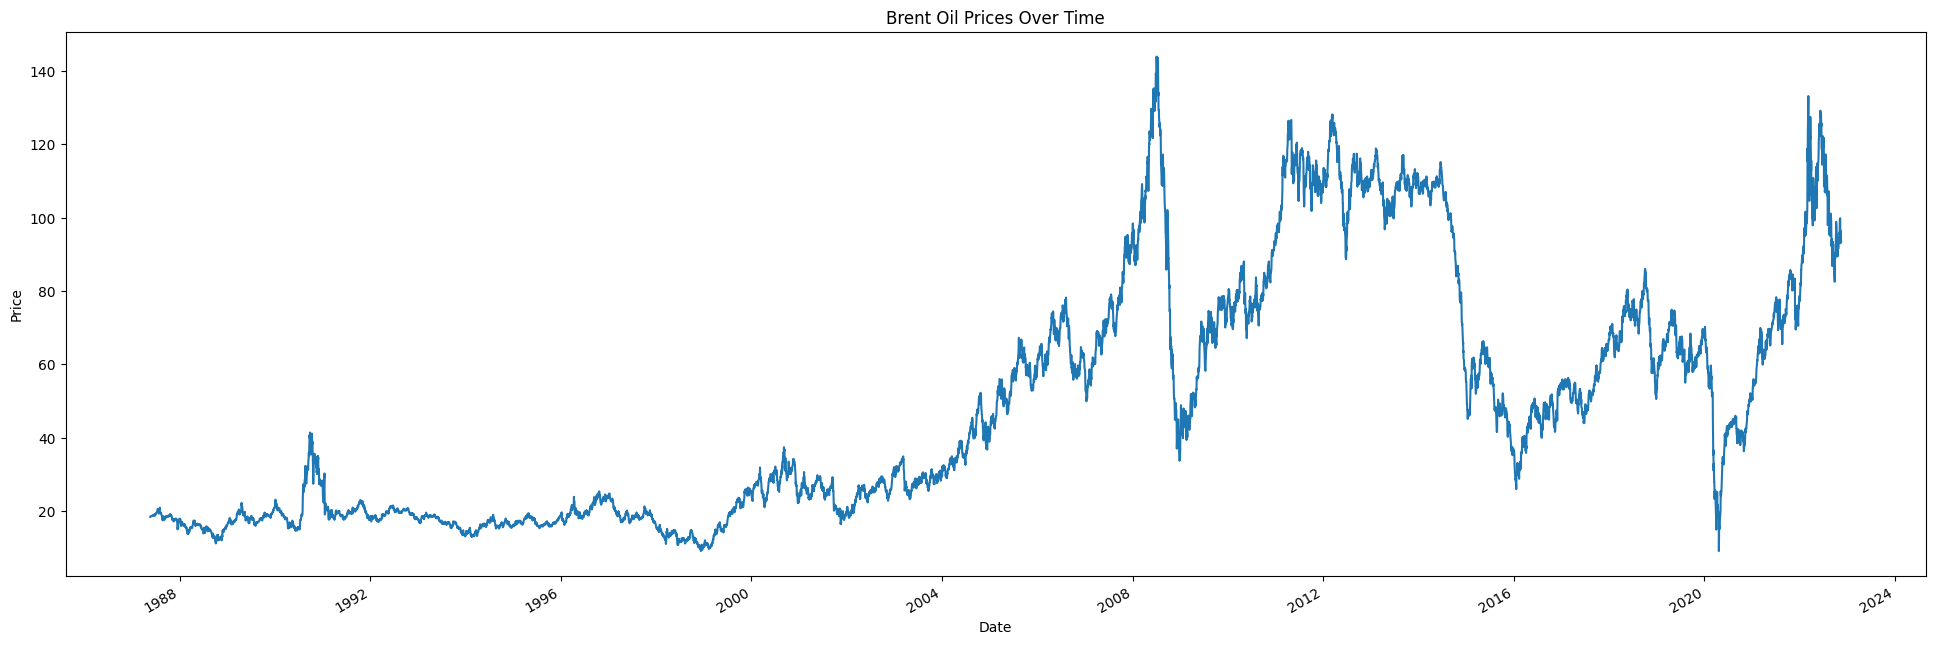

In [8]:
#graph time series
import matplotlib.pyplot as plt
df['Price'].plot(figsize=(24, 8), title='Brent Oil Prices Over Time')
plt.ylabel('Price')
plt.show()

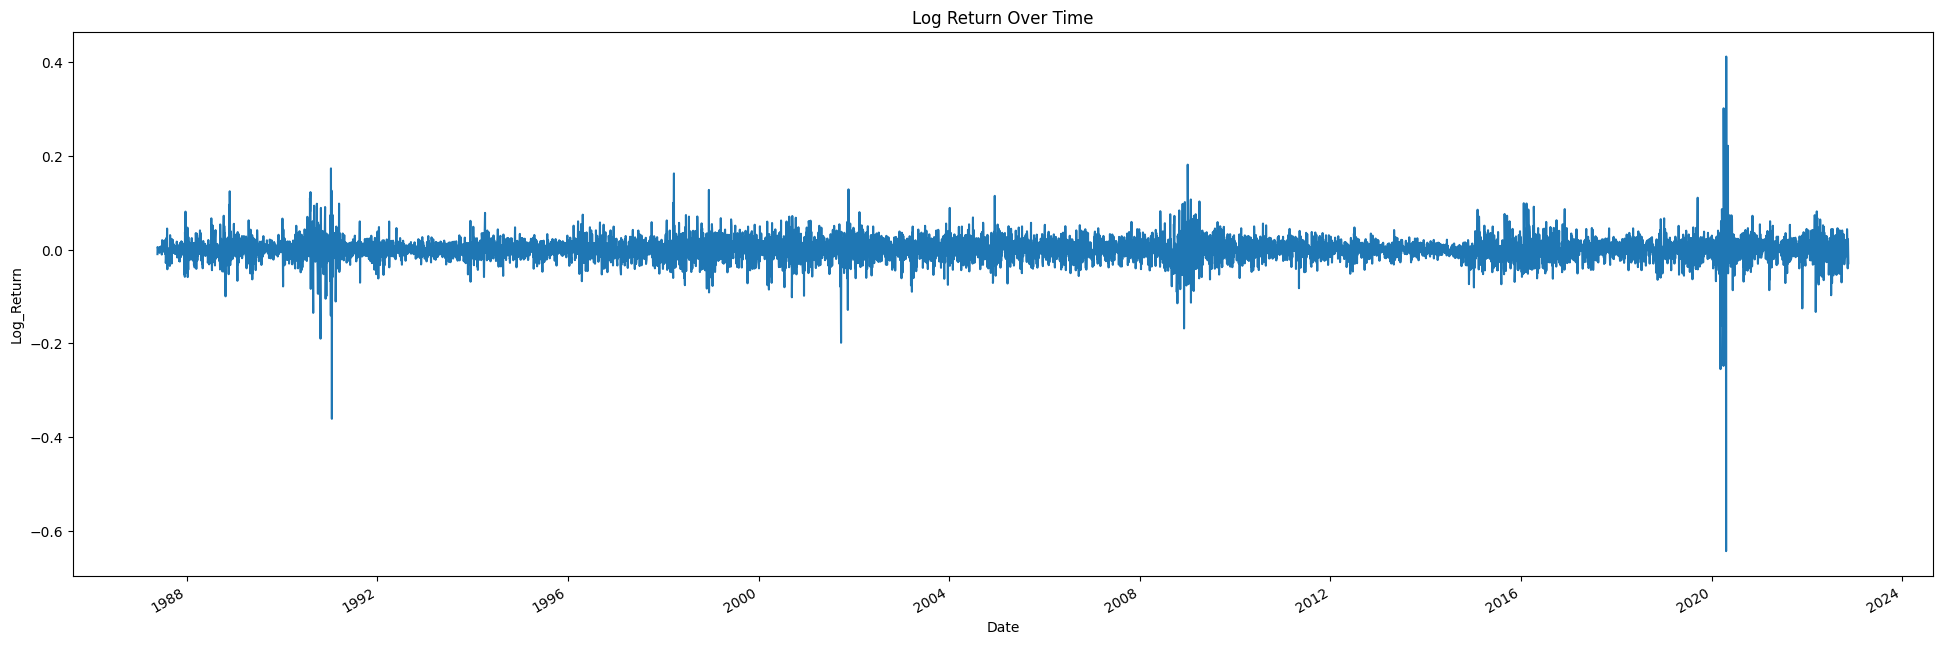

In [ ]:
import matplotlib.pyplot as plt
df['Log_Return'].plot(figsize=(24, 8), title='Log Return Over Time')
plt.ylabel('Log_Return')
plt.show()

##Bayesian Change Point Model

In [6]:
prices = df['Price'].dropna()
x = np.arange(len(prices))
y = prices.values

In [14]:
!apt-get install -y python3-distutils
!apt-get install -y build-essential

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-distutils is already the newest version (3.10.8-1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [15]:
!pip install --upgrade --force-reinstall pymc aesara arviz


  Using cached aesara-2.9.4-py3-none-any.whl.metadata (2.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.5/535.5 kB 18.7 MB/s eta 0:00:00
Using cached aesara-2.9.4-py3-none-any.whl (1.4 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 68.6 MB/s eta 0:00:00
Us

In [7]:
import pymc as pm
import pytensor.tensor as pt

In [10]:
#Bayesian change model
with pm.Model() as model:
    # Change point prior: uniform over all time steps
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(x) - 1)

    # Means before and after the change
    mu1 = pm.Normal("mu1", mu=np.mean(y), sigma=10)
    mu2 = pm.Normal("mu2", mu=np.mean(y), sigma=10)

    # Shared noise level
    sigma = pm.HalfNormal("sigma", sigma=10)

    # Switch based on tau
    mu = pt.switch(x < tau, mu1, mu2)

    # Likelihood
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=y)

    # Sampling
    trace = pm.sample(2000, tune=1000, target_accept=0.95, random_seed=42)


Output()

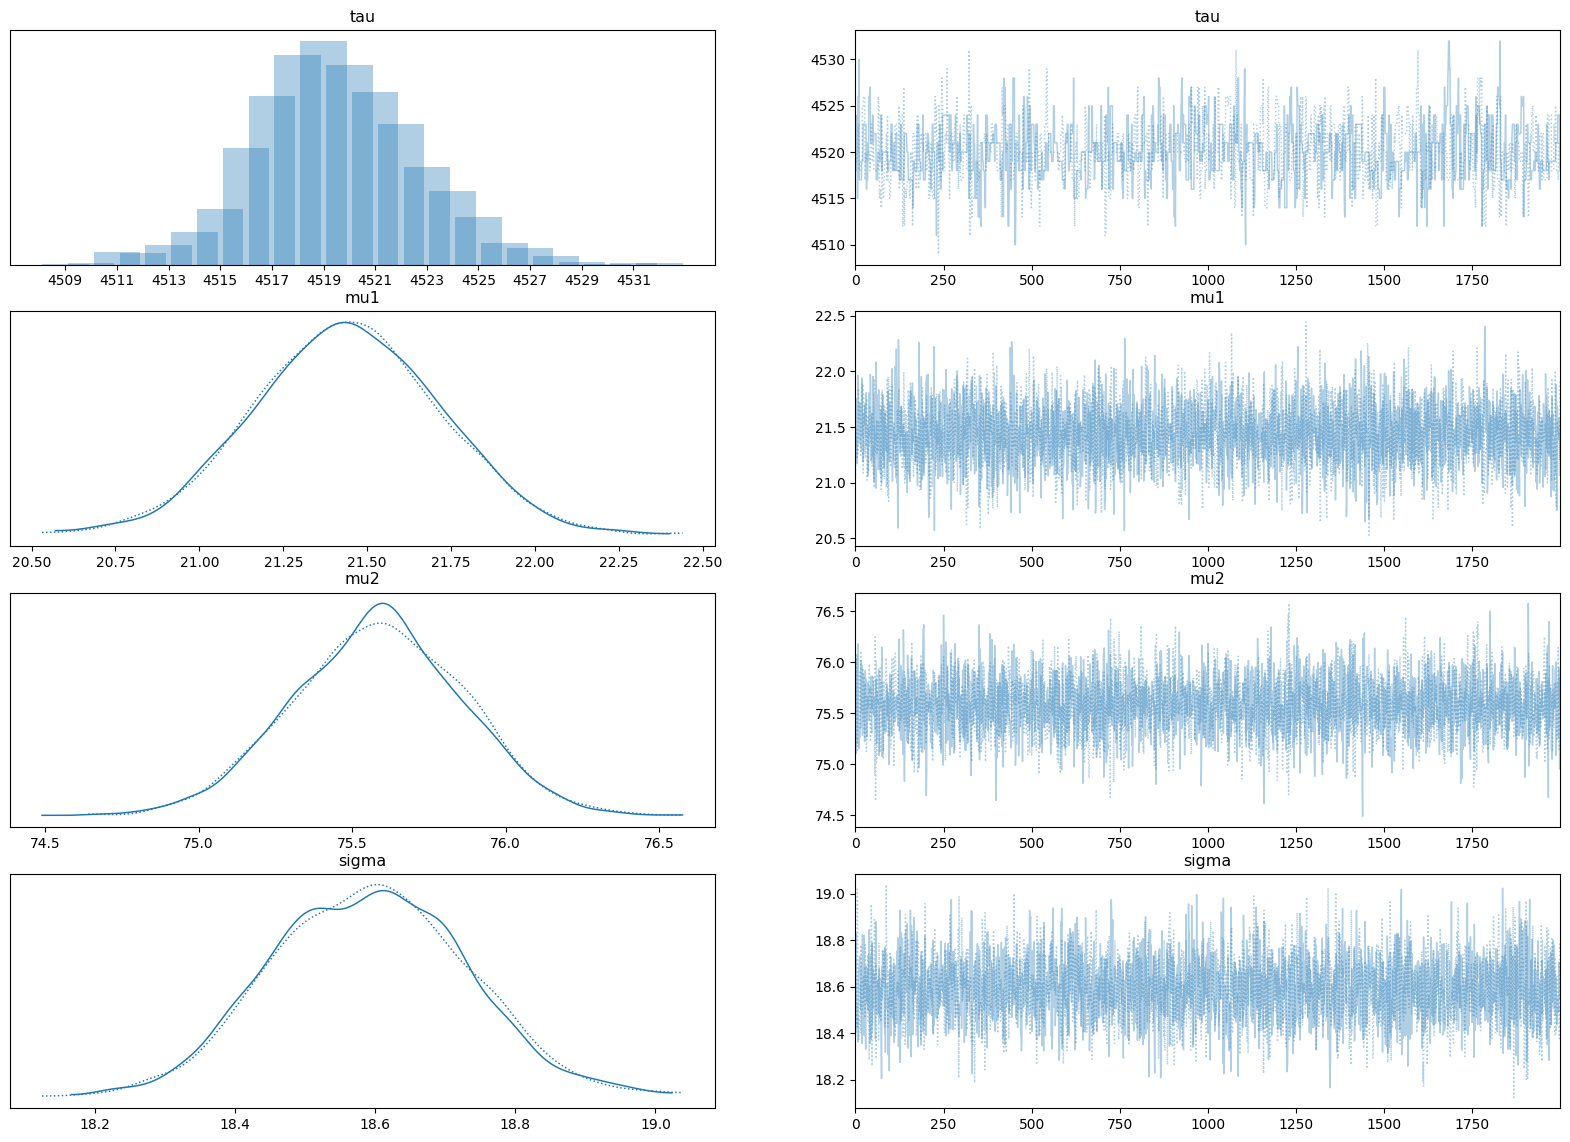

In [14]:
# Posterior summary and trace plot
import arviz as az
az.plot_trace(trace, var_names=["tau", "mu1", "mu2", "sigma"],figsize=(20,14))
plt.show()

In [15]:
# Median change point
tau_median = int(np.median(trace.posterior["tau"].values))
print(f"Estimated change point index: {tau_median}")
print(f"Date: {prices.index[tau_median].date()}")

Estimated change point index: 4520
Date: 2005-02-24


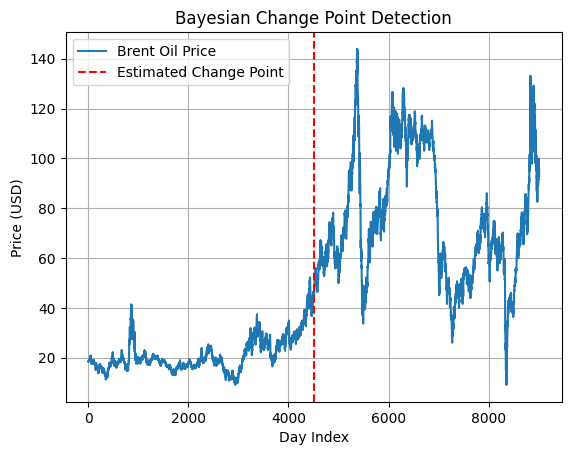

In [16]:
# Plot with change point
plt.plot(x, y, label="Brent Oil Price")
plt.axvline(tau_median, color="red", linestyle="--", label="Estimated Change Point")
plt.title("Bayesian Change Point Detection")
plt.xlabel("Day Index")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Summary statistics (check r_hat ~ 1)
summary = az.summary(trace, var_names=["mu1", "mu2", "tau", "sigma"])
print(summary)


           mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu1      21.439  0.278    20.920    21.956      0.004    0.004    3981.0   
mu2      75.583  0.280    75.050    76.088      0.005    0.005    3470.0   
tau    4520.014  3.151  4513.000  4525.000      0.103    0.099     923.0   
sigma    18.592  0.140    18.326    18.843      0.002    0.002    3140.0   

       ess_tail  r_hat  
mu1      2919.0    1.0  
mu2      2589.0    1.0  
tau       898.0    1.0  
sigma    2596.0    1.0  


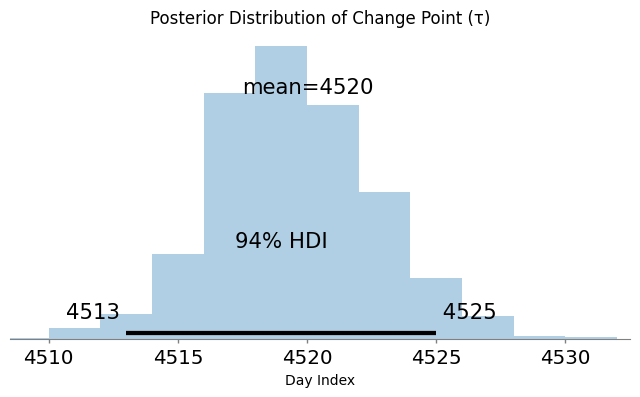

In [21]:
# Posterior distribution of change point
az.plot_posterior(trace, var_names=["tau"], figsize=(8, 4))
plt.title("Posterior Distribution of Change Point (τ)")
plt.xlabel("Day Index")
plt.show()


# Multiple points CPA

In [17]:
!pip install ruptures

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.2 MB/s eta 0:00:00


In [50]:
# Run change point detection
import ruptures as rpt
returns=np.array(df['Log_Return'])
model = "rbf"
algo = rpt.Pelt(model=model).fit(returns)

# Detect change points
change_points = algo.predict(pen=3)

In [51]:
print(change_points)

[145, 165, 815, 980, 2200, 2705, 3825, 5390, 5560, 5915, 6445, 6980, 7510, 8330, 8380, 8820, 9010]


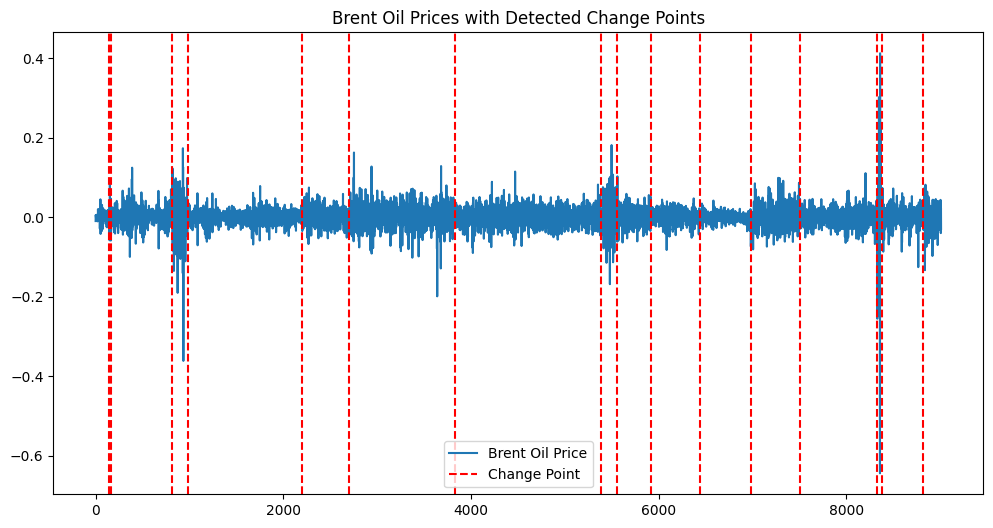

In [52]:
# Plot result
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(returns, label='Brent Oil Price')

for cp in change_points[:-1]:
   plt.axvline(x=cp, color='red', linestyle='--', label='Change Point' if cp == change_points[0] else "")

plt.legend()
plt.title("Brent Oil Prices with Detected Change Points")
plt.show()


In [54]:
df['Date'] = pd.to_datetime(df['Date'])

In [55]:
# Convert change point indices to dates
dates = df["Date"].index[1:]
cp_dates = [dates[i] for i in change_points[:-1]]
print("Detected Change Point Dates:")
for d in cp_dates:
    print(f"- {d.date()}")

Detected Change Point Dates:
- 1987-12-14
- 1988-01-14
- 1990-08-01
- 1991-03-22
- 1996-01-10
- 1998-01-15
- 2002-06-19
- 2008-07-31
- 2009-04-03
- 2010-08-31
- 2012-10-16
- 2014-11-26
- 2016-12-23
- 2020-03-11
- 2020-05-26
- 2022-02-15
